In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)
library(tidytext) 
library(patchwork)
library(cowplot)

# 3. 폰트 로드
loadfonts()


다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



다음의 패키지를 부착합니다: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



다음의 패키지를 부착합니다: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


필요한 패키지를 로딩중입니다: extrafont

Registering fonts with R


다음의 패키지를 부착합니다: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


cmex10 already registered with pdfFont().

cmmi10 already registered with pdfFont().

cmr10 already registered with pdfFont().

cmsy10 already registered with pdfFont().

DejaVu Sans already registered with pdfFont().

DejaVu Sans Condensed already registered with pdfFont().

DejaVu Sans Light already registered with pdfFont().

esint10 already registered

# Step 1. Load data

In [2]:
# 방법 1: paste0() 사용
df_gs <- fread(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/GS.sig.tsv",
)
df_ukb <- fread(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/UKB.sig.tsv",
)

df <- bind_rows(df_gs, df_ukb)

In [3]:
c(dim(df_gs), dim(df_ukb))

[1]  6 23 40 29

In [4]:
method_names <- colnames(df)[!grepl("(^lower_|^upper_|^cohort$|^pheno$)", colnames(df))]
method_names

[1] "RDR"      "HE-CP"    "HE-SD"    "BIGFAM"   "GCTA-snp" "GCTA-ped" "SEM"     
[8] "LDSC"     "LDpred2"

In [5]:
calculate_rsq <- function(df, method_names, n_resampling = 1000) {
  # 데이터프레임에서 해당 method들만 선택
  methods_df <- df %>%
    select(all_of(method_names))
  
  # method 쌍 조합 생성
  method_pairs <- combn(names(methods_df), 2, simplify = FALSE)
  
  # n_resampling번 resampling하여 r-squared 계산
  rsq_results <- map_dfr(method_pairs, function(pair) {
    x <- methods_df[[pair[1]]]
    y <- methods_df[[pair[2]]]
    
    # n_resampling번 resampling
    rsq_values <- replicate(n_resampling, {
      sample_indices <- sample(seq_along(x), replace = TRUE)
      x_sample <- x[sample_indices]
      y_sample <- y[sample_indices]
      summary(lm(y_sample ~ x_sample))$r.squared
    })
    
    bind_rows(
      tibble(
        x = pair[1],
        y = pair[2],
        rsq = list(rsq_values)
      ),
      tibble(
        x = pair[2],
        y = pair[1],
        rsq = list(rsq_values)
      )
    )
  }) %>%
    unnest(rsq)
  
  return(rsq_results)
}

# 함수 사용 예시
rsq_gs <- calculate_rsq(df_gs, setdiff(method_names, c("LDSC", "LDpred2")))
rsq_ukb <- calculate_rsq(df_ukb, method_names)
rsq_all <- calculate_rsq(df, method_names)

Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(y_sample ~ x_sample)):
“essentially perfect fit: summary may be unreliable”
Warning message in 

In [6]:
for_plot <- rsq_gs %>%
  rename(method = x, comparison = y) %>%
  mutate(
    comp_type = case_when(
      comparison %in% c("LDSC", "LDpred2") ~ "summary",
      comparison %in% c("HE-CP", "HE-SD", "RDR", "GCTA-snp", "GCTA-ped") ~ "genotype",
      comparison %in% c("SEM", "BIGFAM") ~ "relationship",
      TRUE ~ NA_character_
    )
  ) 

# 결과 확인
head(for_plot)

method,comparison,rsq,comp_type
<chr>,<chr>,<dbl>,<chr>
RDR,HE-CP,0.9789384,genotype
RDR,HE-CP,0.9831505,genotype
RDR,HE-CP,0.9824716,genotype
RDR,HE-CP,0.9594402,genotype
RDR,HE-CP,0.9819803,genotype
RDR,HE-CP,0.9257327,genotype


In [8]:
rsq_summary <- rsq_ukb %>%
  group_by(x, y) %>%
  summarise(
    mean_rsq = mean(rsq),
    .groups = 'drop'
  ) %>%
  arrange(desc(mean_rsq))

# 결과 확인
rsq_summary %>% filter(x == "BIGFAM")



x,y,mean_rsq
<chr>,<chr>,<dbl>
BIGFAM,LDpred2,0.7912481
BIGFAM,HE-CP,0.7574076
BIGFAM,LDSC,0.7490008
BIGFAM,RDR,0.7479109
BIGFAM,GCTA-snp,0.7336213
BIGFAM,HE-SD,0.7292342
BIGFAM,SEM,0.6280842
BIGFAM,GCTA-ped,0.6051501


# plot theme

In [9]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = NA, color = NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color = "black", fill = NA, size = 0.6),  # size로 선 굵기 조절
            
            # panel.border = element_blank(),  
            
            # 축 설정
            # axis.line.x.top = element_line(color = "black", size = 0.3),  
            # axis.line.y.right = element_line(color = "black", size = 0.3),  
            # axis.line.x.bottom = element_line(color = "black", size = 0.3),  
            # axis.line.y.left = element_line(color = "black", size = 0.3),    
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 메인 figure에 박스 추가
            # plot.background = element_rect(color = "black", fill = NA),
            
            # legend 박스 제거
            legend.box.background = element_blank(),  # 이전: element_rect(color = "black")
            
            # 범례 설정
            legend.margin = margin(1, 1, 1, 1, unit = "mm"),
            # legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
            plot.margin = margin(1, 1, 1, 1, unit = "mm")
        )
}

# Step 2. Plot

In [10]:
# # LDSC 데이터만 필터링하고 통계 계산
# ldsc_summary <- for_plot %>%
#     filter(method == "LDSC") %>%
#     group_by(method, comparison, comp_type) %>%
#     summarise(
#         median_rsq = median(rsq),
#         ci_lower = quantile(rsq, 0.025),
#         ci_upper = quantile(rsq, 0.975),
#         .groups = 'drop'
#     ) %>%
#     arrange(desc(median_rsq)) %>% 
#     mutate(comparison = factor(
#         comparison, 
#         levels = comparison[order(median_rsq, decreasing = TRUE)]))


# comparison_colors <- c(
#   # relationship methods 
#   "BIGFAM" = "#E74C3C",    # 빨간색 (강조)
#   "SEM" = "#F19389",       # 연한 빨간색
  
#   # genotype methods 
#   "GCTA-snp" = "#66C2A5",  # 청록색
#   "GCTA-ped" = "#8FD4BC",  # 연한 청록색
#   "RDR" = "#60B4A3",       
#   "HE-CP" = "#8DA0CB",     # 파란색
#   "HE-SD" = "#ADB9D9",     # 연한 파란색
  
#   # summary methods 
#   "LDpred2" = "#CCCCCC",    # 연한 회색
#   "LDSC" = "#5F5F5F"        # 진한 회색
# )

# # 플롯 생성
# ggplot(ldsc_summary, 
#        aes(x = method, 
#            y = median_rsq, 
#            fill = comparison)) +
#   geom_bar(stat = "identity", 
#            position = position_dodge(width = 0.9),
#            width = 0.8) +
#   geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper),
#                 position = position_dodge(width = 0.9),
#                 width = 0.2) +
#   scale_fill_manual(values = comparison_colors,
#                     name = "Comparison Method") +
#   get_nature_theme() +
#   labs(
#     x = "Method",
#     y = "R-squared"
#   ) +
#   theme(
#     axis.text.x = element_text(angle = 45, hjust = 1),
#     legend.position = "right"
#   ) +
#   coord_cartesian(ylim = c(0.2, 1.0))

In [11]:
# df_summary <-for_plot %>%
#   group_by(method, comparison, comp_type) %>%
#   summarise(
#     median_rsq = median(rsq),
#     ci_lower = quantile(rsq, 0.025),
#     ci_upper = quantile(rsq, 0.975),
#     .groups = 'drop'
#   ) %>%
#   arrange(method, desc(median_rsq)) %>%
#   mutate(
#     across(c(median_rsq, ci_lower, ci_upper), ~round(., 3))  # 소수점 3자리로 반올림
#   )

# write.table(
#   df_summary,
#   "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/GS.summary.tsv",
#   sep = "\t",
#   quote = FALSE,
#   row.names = FALSE
# )


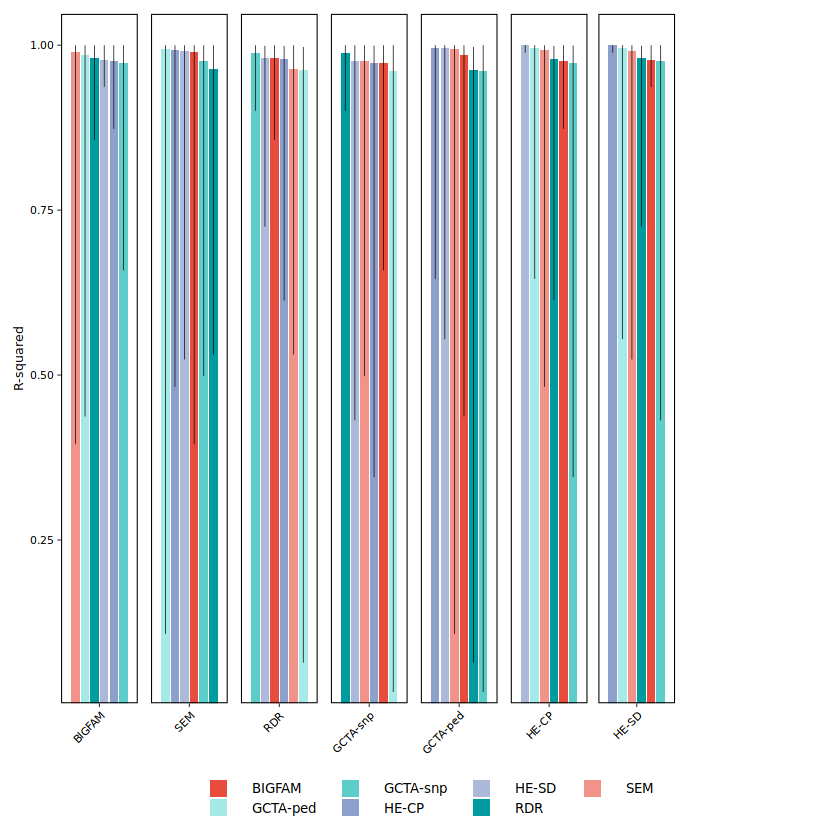

In [15]:
# 모든 method에 대해 plot 생성하는 함수
comparison_colors <- c(
  # relationship methods 
  "BIGFAM" = "#E74C3C",    # 빨간색 (강조)
  "SEM" = "#F19389",       # 연한 빨간색
  
  # genotype methods 
  "RDR" = "#009B9E",  
  "GCTA-snp" = "#5CCDC9",  
  "GCTA-ped" = "#A5EAE7",  

  "HE-CP" = "#8DA0CB",     # 파란색
  "HE-SD" = "#ADB9D9",     # 연한 파란색
  
  # summary methods 
  "LDpred2" = "#CCCCCC",    # 연한 회색
  "LDSC" = "#5F5F5F"        # 진한 회색
)

create_method_plot <- function(data, target_method, is_first = FALSE) {  # is_first 파라미터 추가
  method_summary <- data %>%
    filter(method == target_method) %>%
    group_by(method, comparison, comp_type) %>%
    summarise(
      median_rsq = median(rsq),
      ci_lower = quantile(rsq, 0.025),
      ci_upper = quantile(rsq, 0.975),
      .groups = 'drop'
    ) %>%
    arrange(desc(median_rsq)) %>%
    mutate(comparison = factor(comparison, 
                             levels = comparison[order(median_rsq, decreasing = TRUE)]))
  
  p <- ggplot(method_summary, 
         aes(x = method, 
             y = median_rsq, 
             fill = comparison)) +
    geom_bar(stat = "identity", 
             position = position_dodge(width = 0.9),
             width = 0.8) +
    geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper),
                  position = position_dodge(width = 0.9),
                  width = 0.005,
                  linewidth = 0.2) +
    scale_fill_manual(values = comparison_colors) +
    scale_alpha_manual(
      values = c(
        "summary" = 0.6,
        "genotype" = 1.0,
        "relationship" = 0.8
      )
    ) +
    get_nature_theme() +
    labs(x = NULL, 
         y = if(is_first) "R-squared" else NULL) +  # 첫 번째 plot만 y축 label 표시
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "none",  # 범례 제거
      axis.text.y = if(is_first) element_text() else element_blank(),  # 첫 번째 plot만 y축 텍스트 표시
      axis.ticks.y = if(is_first) element_line() else element_blank()  # 첫 번째 plot만 y축 눈금 표시
    ) +
    coord_cartesian(ylim = c(0.05, 1.0))
  
  return(p)
}

# 모든 method에 대해 plot 생성
method_names <- c(
  # "LDSC", "LDpred2",
  "BIGFAM", "SEM", 
  "RDR", "GCTA-snp", "GCTA-ped", "HE-CP", "HE-SD"
)  # 원하는 순서로 변경


method_plots <- map2(
  method_names,
  c(TRUE, rep(FALSE, length(method_names)-1)),  # 첫 번째만 TRUE, 나머지는 FALSE
  ~create_method_plot(for_plot, .x, .y)
)

# plots를 row-wise로 결합 (간격 줄이기)
combined_plot <- wrap_plots(method_plots, ncol = 9) +
  plot_layout(guides = 'collect') +  # legend 통합
  plot_layout(widths = rep(1, 3)) +  # 너비 동일하게
  theme(plot.margin = margin(0.5, 0.5, 0.5, 0.5, "mm"))  # 전체적인 마진 줄이기

# Legend를 위한 더미 plot 생성
legend_plot <- ggplot(for_plot, 
       aes(x = method, 
           y = rsq, 
           fill = comparison)) +
    geom_bar(stat = "identity") +
    scale_fill_manual(values = comparison_colors,
                     name = NULL) +
    theme_void() +  # 플롯 내용은 보이지 않게
    theme(legend.position = "bottom",
          legend.box = "horizontal",
          legend.margin = margin(t = 0, r = 0, b = 10, l = 0),
          legend.spacing.x = unit(0.5, 'cm'),
          legend.text = element_text(size = 8),  # 글자 크기 증가
          legend.title = element_text(size = 9),  # 제목 크기 증가
          legend.key.size = unit(0.8, 'lines'),  # box 크기 감소
          legend.direction = "horizontal",  # 가로 방향으로 배치
          legend.box.spacing = unit(0.2, 'cm'))  # legend box 간격 조정

# Legend만 추출
legend <- get_legend(legend_plot)

# plots와 legend 결합
final_plot <- plot_grid(
    combined_plot,
    legend,
    ncol = 1,
    rel_heights = c(0.92, 0.08)  # legend 공간 약간 줄임
)

final_plot


In [16]:
# Save plot
ggsave(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/GS.other-methods.pdf",
    plot = final_plot,
    width = 183,
    height = 80,
    dpi = 300,
    units = "mm"
)